# MaskRCNN Indoor Segmentation


## Install Matterport Mask-RCNN in Google Colab

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
!pip3 uninstall -y keras
!pip3 install keras==2.1.0

Uninstalling Keras-2.3.1:
  Successfully uninstalled Keras-2.3.1
     |████████████████████████████████| 307kB 16.8MB/s 
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.1.0 which is incompatible.
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [ ]:
!git clone https://github.com/matterport/Mask_RCNN
%cd Mask_RCNN
#!pip3 install -r requirements.txt
!python3 setup.py install

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 40.04 MiB/s, done.
Resolving deltas: 100% (562/562), done.
/content/Mask_RCNN
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:645: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:645: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:645: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in future versions. Please use the underscore name 'requirements_file' instead
  % (opt, underscore_opt))
running i

In [ ]:
!git clone https://github.com/cocodataset/cocoapi.git
%cd cocoapi/PythonAPI
!make
%cd ../../

Cloning into 'cocoapi'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 33.07 MiB/s, done.
Resolving deltas: 100% (576/576), done.
/content/Mask_RCNN/cocoapi/PythonAPI
python setup.py build_ext --inplace
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/usr/local/lib/python3.7/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/Mask_RCNN/cocoapi/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/pycocotools
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-a56wZI/python3.7-3.

## Imports

In [ ]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


... done downloading pretrained model!


## Configurations

In [ ]:
class IndoorNavConfig(Config):
    # Give the configuration a recognizable name
    NAME = "indoor_segmentation"
    
    NUM_CLASSES = 1 + 13

    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = IndoorNavConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                26
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset

In [ ]:
#!wget https://github.com/TannerGilbert/Detectron2-Train-a-Instance-Segmentation-Model/raw/master/microcontroller_segmentation_data.zip
!unzip '/content/drive/MyDrive/Mask RCNN/MaskRCNN-Object-Detection-and-Segmentation-master/navdata.zip'

Archive:  /content/drive/MyDrive/Mask RCNN/MaskRCNN-Object-Detection-and-Segmentation-master/navdata.zip
  inflating: navdata/create_coco_tf_record.py  
  inflating: navdata/labelme2coco.py  
  inflating: navdata/test.json       
   creating: navdata/test/
  inflating: navdata/test/1000.json  
  inflating: navdata/test/1000.png   
  inflating: navdata/test/1002.json  
  inflating: navdata/test/1002.png   
  inflating: navdata/test/1003.json  
  inflating: navdata/test/1003.png   
  inflating: navdata/test/1004.json  
  inflating: navdata/test/1004.png   
  inflating: navdata/test/1005.json  
  inflating: navdata/test/1005.png   
  inflating: navdata/test/1006.json  
  inflating: navdata/test/1006.png   
  inflating: navdata/test/1007.json  
  inflating: navdata/test/1007.png   
  inflating: navdata/test/1008.json  
  inflating: navdata/test/1008.png   
  inflating: navdata/test/1009.json  
  inflating: navdata/test/1009.png   
  inflating: navdata/test/1011.json  
  inflating: navdata/

In [ ]:
class IndoorDataset(utils.Dataset):
    def load_dataset(self, dataset_dir):
        self.add_class('dataset', 1, 'bed')
        self.add_class('dataset', 2, 'chair')
        self.add_class('dataset', 3, 'cupboard')
        self.add_class('dataset', 4, 'door')
        self.add_class('dataset', 5, 'drawer')
        self.add_class('dataset', 6, 'dustbin')
        self.add_class('dataset', 7, 'fire extinguisher')
        self.add_class('dataset', 8, 'lamp')
        self.add_class('dataset', 9, 'painting')
        self.add_class('dataset', 10, 'sofa')
        self.add_class('dataset', 11, 'table')
        self.add_class('dataset', 12, 'wall')
        self.add_class('dataset', 13, 'window')
        
        # find all images
        for i, filename in enumerate(os.listdir(dataset_dir)):
            if '.png' in filename:
                self.add_image('dataset', 
                               image_id=i, 
                               path=os.path.join(dataset_dir, filename), 
                               annotation=os.path.join(dataset_dir, filename.replace('.png', '.json')))
    
    def extract_masks(self, filename):
        json_file = os.path.join(filename)
        with open(json_file) as f:
            img_anns = json.load(f)
            
        masks = np.zeros([600, 800, len(img_anns['shapes'])], dtype='uint8')
        classes = []
        for i, anno in enumerate(img_anns['shapes']):
            mask = np.zeros([600, 800], dtype=np.uint8)
            cv2.fillPoly(mask, np.array([anno['points']], dtype=np.int32), 1)
            masks[:, :, i] = mask
            classes.append(self.class_names.index(anno['label']))
        return masks, classes
 
    # load the masks for an image
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        # load XML
        masks, classes = self.extract_masks(path)
        return masks, np.asarray(classes, dtype='int32')
    
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

In [ ]:
# Create training and validation set
# train set
dataset_train = IndoorDataset()
dataset_train.load_dataset('/content/drive/MyDrive/Mask RCNN/MaskRCNN-Object-Detection-and-Segmentation-master/navdata/train')
dataset_train.prepare()
print('Train: %d' % len(dataset_train.image_ids))
 
# test/val set
dataset_val = IndoorDataset()
dataset_val.load_dataset('/content/drive/MyDrive/Mask RCNN/MaskRCNN-Object-Detection-and-Segmentation-master/navdata/test')
dataset_val.prepare()
print('Test: %d' % len(dataset_val.image_ids))

Train: 197
Test: 121


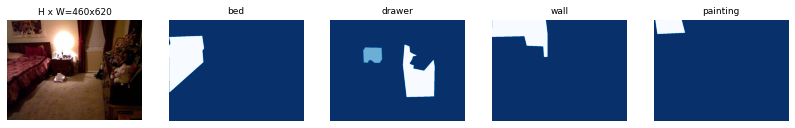

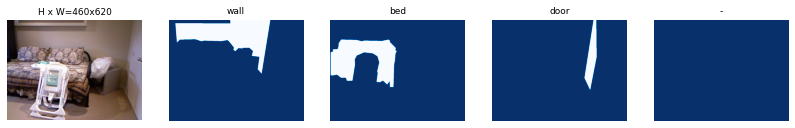

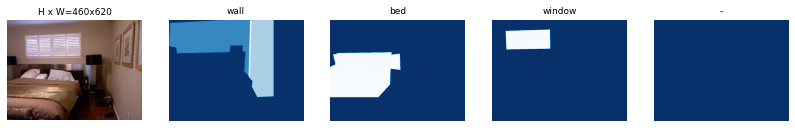

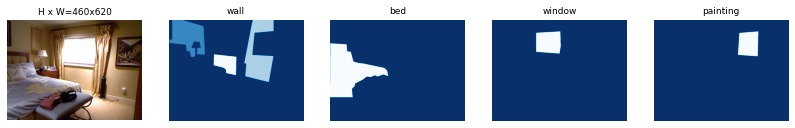

In [ ]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [ ]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [ ]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=5, 
            layers='heads')

# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=10, 
            layers="all")



Starting at epoch 0. LR=0.001

Checkpoint Path: /content/logs/indoor_segmentation20210423T1738/mask_rcnn_indoor_segmentation_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistribute

/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor





/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/5
 999/1000 [============================>.] - ETA: 0s - loss: 1.4095 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.3495 - mrcnn_class_loss: 0.3632 - mrcnn_bbox_loss: 0.3235 - mrcnn_mask_loss: 0.3506

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2197: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'



1000/1000 [==============================] - 630s 630ms/step - loss: 1.4088 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.3493 - mrcnn_class_loss: 0.3631 - mrcnn_bbox_loss: 0.3233 - mrcnn_mask_loss: 0.3504 - val_loss: 1.0994 - val_rpn_class_loss: 0.0165 - val_rpn_bbox_loss: 0.2922 - val_mrcnn_class_loss: 0.3504 - val_mrcnn_bbox_loss: 0.1857 - val_mrcnn_mask_loss: 0.2545
Epoch 2/5
1000/1000 [==============================] - 559s 559ms/step - loss: 0.8855 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.2382 - mrcnn_class_loss: 0.2379 - mrcnn_bbox_loss: 0.1586 - mrcnn_mask_loss: 0.2372 - val_loss: 0.7559 - val_rpn_class_loss: 0.0121 - val_rpn_bbox_loss: 0.1991 - val_mrcnn_class_loss: 0.2013 - val_mrcnn_bbox_loss: 0.1215 - val_mrcnn_mask_loss: 0.2218
Epoch 3/5
1000/1000 [==============================] - 560s 560ms/step - loss: 0.6922 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.1858 - mrcnn_class_loss: 0.1732 - mrcnn_bbox_loss: 0.1125 - mrcnn_mask_loss: 0.2091 - val_loss: 0.6420 - val_rpn_clas

/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers 

Epoch 6/10
 999/1000 [============================>.] - ETA: 0s - loss: 0.3431 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0716 - mrcnn_class_loss: 0.0796 - mrcnn_bbox_loss: 0.0412 - mrcnn_mask_loss: 0.1424

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2197: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


1000/1000 [==============================] - 944s 944ms/step - loss: 0.3430 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0716 - mrcnn_class_loss: 0.0796 - mrcnn_bbox_loss: 0.0412 - mrcnn_mask_loss: 0.1424 - val_loss: 0.2804 - val_rpn_class_loss: 0.0090 - val_rpn_bbox_loss: 0.0466 - val_mrcnn_class_loss: 0.0688 - val_mrcnn_bbox_loss: 0.0288 - val_mrcnn_mask_loss: 0.1272
Epoch 7/10
1000/1000 [==============================] - 880s 880ms/step - loss: 0.2890 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.0506 - mrcnn_class_loss: 0.0686 - mrcnn_bbox_loss: 0.0305 - mrcnn_mask_loss: 0.1319 - val_loss: 0.2797 - val_rpn_class_loss: 0.0095 - val_rpn_bbox_loss: 0.0447 - val_mrcnn_class_loss: 0.0662 - val_mrcnn_bbox_loss: 0.0307 - val_mrcnn_mask_loss: 0.1286
Epoch 8/10
1000/1000 [==============================] - 879s 879ms/step - loss: 0.2587 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.0407 - mrcnn_class_loss: 0.0603 - mrcnn_bbox_loss: 0.0267 - mrcnn_mask_loss: 0.1241 - val_loss: 0.2488 - val_rpn_cla

## Detection

In [ ]:
class InferenceConfig(IndoorNavConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /content/logs/indoor_segmentation20210423T1738/mask_rcnn_indoor_segmentation_0010.h5
Re-starting from epoch 10


In [ ]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [ ]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)


#visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, dataset_train.class_names, figsize=(8, 8))
print(dataset_train.class_names)

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (26,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (5,)                  min:    1.00000  max:   12.00000  int32
gt_bbox                  shape: (5, 4)                min:   82.00000  max: 1024.00000  int32
gt_mask                  shape: (1255, 1321, 5)       min:    0.00000  max:    1.00000  uint8
['BG', 'bed', 'chair', 'cupboard', 'door', 'drawer', 'dustbin', 'fire extinguisher', 'lamp', 'painting', 'sofa', 'table', 'wall', 'window']


Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 26)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


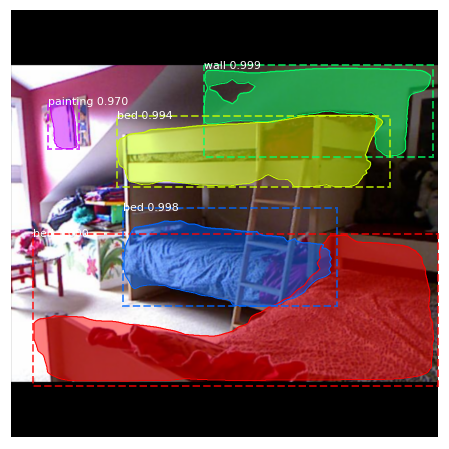

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [ ]:

print(r['class_ids'])
print(gt_class_id)
print(class_ids)


[ 1 12  1  1  9]
[ 1  1  1 12  9]
[ 1  9  5 13  8 12 12 12]


In [ ]:
print(dataset_train.class_names)

['BG', 'bed', 'chair', 'cupboard', 'door', 'drawer', 'dustbin', 'fire extinguisher', 'lamp', 'painting', 'sofa', 'table', 'wall', 'window']


In [ ]:
f=dataset_train.class_names
print(f)

['BG', 'bed', 'chair', 'cupboard', 'door', 'drawer', 'dustbin', 'fire extinguisher', 'lamp', 'painting', 'sofa', 'table', 'wall', 'window']


In [ ]:
idd = r['class_ids']
print(id_class_)

[ 1 12  1  1  9]


In [ ]:
for i in idd:
  print("THERE IS A :",f[i])

THERE IS A : bed
THERE IS A : wall
THERE IS A : bed
THERE IS A : bed
THERE IS A : painting


In [ ]:
model_path = os.path.join(MODEL_DIR, 'indoornav_trained_model.h5')
model.keras_model.save_weights(model_path)

In [ ]:
print(model_path)

/content/logs/indoornav_trained_model.h5


In [ ]:
model.load_weights(model_path, by_name=True)
video_path = (r"/content/drive/MyDrive/Mask RCNN/MaskRCNN-Object-Detection-and-Segmentation-master/indoor.mp4")
    
cap = cv2.VideoCapture(video_path)
width = int(cap.get(3))
height = int(cap.get(4))
fps = cap.get(cv2.CAP_PROP_FPS)
out = cv2.VideoWriter(args.save_path, cv2.VideoWriter_fourcc('M','J','P','G'), fps, (width, height))
while cap.isOpened():
        ret, image = cap.read()
        results = model.detect([image], verbose=1)
        r = results[0]
        image = visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())
      
        cv2.imshow('MaskRCNN Object Detection/Instance Segmentation', image)
        if cv2.waitKey(1) & 0xFF == ord('q'):
                break

cv2.destroyAllWindows()